In [ ]:
# Visual Comparison: Raw vs Preprocessed (Multi-Patient Samples)
import matplotlib.pyplot as plt
import random

def show_preprocessing_comparison(patient_folders, num_samples=3):
    """
    Show side-by-side comparison of raw vs preprocessed for random patient samples
    """
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    fig.suptitle('Multi-Patient Preprocessing Comparison (Raw → Preprocessed)', fontsize=16, fontweight='bold')
    
    # Sample random patients and slices
    sample_patients = random.sample(list(patient_folders), min(num_samples, len(patient_folders)))
    
    for i, patient_folder in enumerate(sample_patients):
        try:
            # Load raw MRI data
            seg_folder = patient_folder / "sayyad habib MRI" / "segmented sayyad habib"
            nii_files = list(seg_folder.glob("*DWI*.nii"))
            if not nii_files:
                continue
                
            img_itk = sitk.ReadImage(str(nii_files[0]))
            raw_volume = sitk.GetArrayFromImage(img_itk).astype(np.float32)
            
            # Apply preprocessing
            processed_volume = production_mri_preprocessing(raw_volume, target_size=(256, 256))
            
            # Pick middle slice for visualization
            mid_slice = raw_volume.shape[0] // 2
            
            # Show raw slice (original size)
            axes[i, 0].imshow(raw_volume[mid_slice], cmap='gray')
            axes[i, 0].set_title(f'{patient_folder.name}\nRaw ({raw_volume[mid_slice].shape})')
            axes[i, 0].axis('off')
            
            # Show raw slice resized to 256x256 for fair comparison
            raw_resized = cv2.resize(raw_volume[mid_slice], (256, 256), interpolation=cv2.INTER_AREA)
            axes[i, 1].imshow(raw_resized, cmap='gray')
            axes[i, 1].set_title(f'Raw Resized\n(256x256)')
            axes[i, 1].axis('off')
            
            # Show preprocessed slice
            axes[i, 2].imshow(processed_volume[mid_slice], cmap='gray')
            axes[i, 2].set_title(f'Preprocessed\n(256x256)')
            axes[i, 2].axis('off')
            
            # Show intensity histogram comparison
            axes[i, 3].hist(raw_volume[mid_slice].flatten(), bins=50, alpha=0.7, label='Raw', color='blue')
            axes[i, 3].hist(processed_volume[mid_slice].flatten(), bins=50, alpha=0.7, label='Processed', color='red')
            axes[i, 3].set_title('Intensity Distribution')
            axes[i, 3].legend()
            axes[i, 3].set_xlabel('Intensity')
            axes[i, 3].set_ylabel('Frequency')
            
            print(f"📊 {patient_folder.name}:")
            print(f"  Raw: {raw_volume.shape} | Range: [{raw_volume.min():.1f}, {raw_volume.max():.1f}]")
            print(f"  Processed: {processed_volume.shape} | Range: [{processed_volume.min():.3f}, {processed_volume.max():.3f}]")
            
        except Exception as e:
            print(f"❌ Error processing {patient_folder.name}: {e}")
    
    plt.tight_layout()
    plt.show()

# Show comparison after preprocessing is complete
if len(preprocessing_results) > 0:
    print("🎨 Showing visual comparison of preprocessing effects...")
    show_preprocessing_comparison(patient_folders, num_samples=min(3, len(patient_folders)))
else:
    print("⚠️ Run preprocessing first to see visual comparison")

In [1]:
# Verify that isoReg DWI in original and segmented folders correspond (read-only)
from pathlib import Path
import json

orig_dir = Path("mRs-prediction-3patient/sayyad habib CTA/sayyad habib MRI/1.3.46.670589.54.2.39595856851039510601.30159219094231274361")
seg_dir = Path("mRs-prediction-3patient/sayyad habib CTA/sayyad habib MRI/segmented sayyad habib")

orig_img = orig_dir/"SAYYAD_HABIB_65Y_M_SK_isoReg_-_DWI_HR.nii"
seg_img  = seg_dir/"SAYYAD_HABIB_65Y_M_SK_isoReg_-_DWI_HR.nii"
seg_file = seg_dir/"Segmentation.seg.nrrd"

print("Original isoReg DWI:", orig_img.exists(), orig_img)
print("Segmented isoReg DWI:", seg_img.exists(), seg_img)
print("Segmentation file:", seg_file.exists(), seg_file)

# Compare JSON sidecars if present for acquisition/space metadata
orig_json = orig_dir/"SAYYAD_HABIB_65Y_M_SK_isoReg_-_DWI_HR.json"
seg_json  = seg_dir/"SAYYAD_HABIB_65Y_M_SK_isoReg_-_DWI_HR.json"
print("Original JSON exists:", orig_json.exists(), orig_json)
print("Segmented JSON exists:", seg_json.exists(), seg_json)

if orig_json.exists():
    with open(orig_json, 'r') as f:
        oj = json.load(f)
    print("Original dims (if present):", oj.get("dim") or (oj.get("Columns"), oj.get("Rows")))

if seg_json.exists():
    with open(seg_json, 'r') as f:
        sj = json.load(f)
    print("Segmented dims (if present):", sj.get("dim") or (sj.get("Columns"), sj.get("Rows")))

# If nibabel is available, read headers only (no data modification)
try:
    import nibabel as nib
    o = nib.load(str(orig_img))
    s = nib.load(str(seg_img))
    print("Shapes (orig vs seg copy):", o.shape, s.shape)
    print("Zooms  (orig vs seg copy):", o.header.get_zooms(), s.header.get_zooms())
    print("Affine equal:", (o.affine == s.affine).all())
except Exception as e:
    print("nibabel check skipped:", e)

# For the segmentation .seg.nrrd, confirm it references same geometry via SimpleITK if available
try:
    import SimpleITK as sitk
    seg = sitk.ReadImage(str(seg_file))
    o = sitk.ReadImage(str(orig_img))
    print("NRRD mask size:", seg.GetSize(), "spacing:", seg.GetSpacing(), "direction:", seg.GetDirection())
    print("Orig DWI size:", o.GetSize(), "spacing:", o.GetSpacing(), "direction:", o.GetDirection())
except Exception as e:
    print("SimpleITK check skipped:", e)

Original isoReg DWI: True mRs-prediction-3patient/sayyad habib CTA/sayyad habib MRI/1.3.46.670589.54.2.39595856851039510601.30159219094231274361/SAYYAD_HABIB_65Y_M_SK_isoReg_-_DWI_HR.nii
Segmented isoReg DWI: True mRs-prediction-3patient/sayyad habib CTA/sayyad habib MRI/segmented sayyad habib/SAYYAD_HABIB_65Y_M_SK_isoReg_-_DWI_HR.nii
Segmentation file: True mRs-prediction-3patient/sayyad habib CTA/sayyad habib MRI/segmented sayyad habib/Segmentation.seg.nrrd
Original JSON exists: True mRs-prediction-3patient/sayyad habib CTA/sayyad habib MRI/1.3.46.670589.54.2.39595856851039510601.30159219094231274361/SAYYAD_HABIB_65Y_M_SK_isoReg_-_DWI_HR.json
Segmented JSON exists: False mRs-prediction-3patient/sayyad habib CTA/sayyad habib MRI/segmented sayyad habib/SAYYAD_HABIB_65Y_M_SK_isoReg_-_DWI_HR.json
Original dims (if present): (None, None)
Shapes (orig vs seg copy): (256, 256, 25) (256, 256, 25)
Zooms  (orig vs seg copy): (np.float32(0.8984375), np.float32(0.8984375), np.float32(6.0)) (np.f

## Export Raw MRI Slices - Multi-Patient Support

In [7]:
# Export Raw MRI Slices - Multi-Patient Support
from pathlib import Path
import numpy as np
import SimpleITK as sitk
from PIL import Image
import os

def process_patient_raw_export(patient_folder, output_base_dir="images"):
    """
    Export raw MRI slices for a single patient
    """
    # Find the segmented folder and .nii file
    seg_folder = patient_folder / "sayyad habib MRI" / "segmented sayyad habib"
    
    # Look for the DWI .nii file
    nii_files = list(seg_folder.glob("*DWI*.nii"))
    if not nii_files:
        print(f"❌ No DWI .nii file found in {seg_folder}")
        return False
    
    img_path = nii_files[0]  # Use first DWI file found
    patient_name = patient_folder.name.replace(" ", "_")
    
    print(f"📂 Processing patient: {patient_name}")
    print(f"📄 Loading: {img_path.name}")
    
    # Load the MRI data
    img_itk = sitk.ReadImage(str(img_path))
    img_zyx = sitk.GetArrayFromImage(img_itk).astype(np.float32)
    
    print(f"  📊 Shape: {img_zyx.shape}")
    print(f"  📊 Value range: [{img_zyx.min():.2f}, {img_zyx.max():.2f}]")
    
    # Create patient-specific output directory
    raw_out_dir = Path(output_base_dir) / "mri_raw" / patient_name
    raw_out_dir.mkdir(parents=True, exist_ok=True)
    
    # Simple conversion to 8-bit for visualization
    def raw_to_uint8(vol):
        vol_min, vol_max = vol.min(), vol.max()
        if vol_max <= vol_min:
            return np.zeros_like(vol, dtype=np.uint8)
        vol_scaled = (vol - vol_min) / (vol_max - vol_min)
        return (vol_scaled * 255).astype(np.uint8)
    
    img_raw_u8 = raw_to_uint8(img_zyx)
    n_slices = img_raw_u8.shape[0]
    
    print(f"  💾 Saving {n_slices} raw slices to {raw_out_dir}")
    
    # Save all slices
    for z in range(n_slices):
        img_slice = Image.fromarray(img_raw_u8[z])
        filename = f"{patient_name}-slice{z:03d}_z.png"
        img_slice.save(raw_out_dir / filename)
        if z % 10 == 0:  # Progress every 10 slices
            print(f"    Progress: {z+1}/{n_slices} slices...")
    
    print(f"  ✅ Completed: {n_slices} slices exported")
    return True, img_zyx.shape, (img_zyx.min(), img_zyx.max())

# Process all patients in mRs-prediction-3patient folder
base_dir = Path("mRs-prediction-3patient")
patient_folders = [f for f in base_dir.iterdir() if f.is_dir()]

print(f"🔍 Found {len(patient_folders)} patient folders:")
for folder in patient_folders:
    print(f"  📁 {folder.name}")

print(f"\n🚀 Starting raw export for all patients...")
print("=" * 60)

processed_patients = []
for patient_folder in patient_folders:
    try:
        success, shape, value_range = process_patient_raw_export(patient_folder)
        if success:
            processed_patients.append({
                'name': patient_folder.name,
                'shape': shape,
                'value_range': value_range
            })
    except Exception as e:
        print(f"❌ Error processing {patient_folder.name}: {e}")
    print()

print(f"\n📈 SUMMARY:")
print(f"✅ Successfully processed: {len(processed_patients)} patients")
for patient in processed_patients:
    print(f"  {patient['name']}: {patient['shape']} | Range: [{patient['value_range'][0]:.1f}, {patient['value_range'][1]:.1f}]")

🔍 Found 1 patient folders:
  📁 sayyad habib CTA

🚀 Starting raw export for all patients...
📂 Processing patient: sayyad_habib_CTA
📄 Loading: SAYYAD_HABIB_65Y_M_SK_isoReg_-_DWI_HR.nii
  📊 Shape: (25, 256, 256)
  📊 Value range: [0.00, 4095.00]
  💾 Saving 25 raw slices to images/mri_raw/sayyad_habib_CTA
    Progress: 1/25 slices...
    Progress: 11/25 slices...
    Progress: 21/25 slices...
  ✅ Completed: 25 slices exported


📈 SUMMARY:
✅ Successfully processed: 1 patients
  sayyad habib CTA: (25, 256, 256) | Range: [0.0, 4095.0]


## Standard MRI Preprocessing - Multi-Patient Support (256x256)

In [8]:
# Standard MRI Preprocessing - Multi-Patient Support (256x256)
import cv2

def production_mri_preprocessing(mri_volume, target_size=(256, 256)):
    """
    Production preprocessing for 200+ patient stroke dataset
    4 mandatory steps: dimension, intensity, data type, robust normalization
    Keeping 256x256 for better resolution
    """
    processed_slices = []
    
    for z in range(mri_volume.shape[0]):
        # Get 2D slice
        slice_2d = mri_volume[z]
        
        # Step 1: DIMENSION STANDARDIZATION - Resize to consistent size
        if slice_2d.shape != target_size:
            slice_2d = cv2.resize(slice_2d, target_size, interpolation=cv2.INTER_AREA)
        
        # Step 2: INTENSITY NORMALIZATION - Scale to [0,1]
        slice_2d = slice_2d.astype(np.float32)
        slice_min, slice_max = slice_2d.min(), slice_2d.max()
        if slice_max > slice_min:
            slice_2d = (slice_2d - slice_min) / (slice_max - slice_min)
        
        # Step 3: DATA TYPE STANDARDIZATION - Ensure float32
        slice_2d = slice_2d.astype(np.float32)
        
        # Step 4: ROBUST INTENSITY STANDARDIZATION - Z-score for brain regions
        brain_mask = slice_2d > 0.05  # threshold to exclude background
        if np.sum(brain_mask) > 0:
            brain_pixels = slice_2d[brain_mask]
            brain_mean = np.mean(brain_pixels)
            brain_std = np.std(brain_pixels)
            if brain_std > 0:  # avoid division by zero
                slice_2d[brain_mask] = (brain_pixels - brain_mean) / brain_std
                # Rescale to [0,1] range after z-score
                slice_2d = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min() + 1e-8)
        
        # Ensure values are in valid range
        slice_2d = np.clip(slice_2d, 0, 1)
        processed_slices.append(slice_2d)
    
    return np.array(processed_slices)

def process_patient_preprocessing(patient_folder, output_base_dir="images"):
    """
    Apply standard preprocessing to a single patient
    """
    # Find the segmented folder and .nii file
    seg_folder = patient_folder / "sayyad habib MRI" / "segmented sayyad habib"
    nii_files = list(seg_folder.glob("*DWI*.nii"))
    
    if not nii_files:
        print(f"❌ No DWI .nii file found in {seg_folder}")
        return False
    
    img_path = nii_files[0]
    patient_name = patient_folder.name.replace(" ", "_")
    
    print(f"🔧 Preprocessing patient: {patient_name}")
    
    # Load the MRI data
    img_itk = sitk.ReadImage(str(img_path))
    img_zyx = sitk.GetArrayFromImage(img_itk).astype(np.float32)
    
    print(f"  📊 Input: {img_zyx.shape} | Range: [{img_zyx.min():.2f}, {img_zyx.max():.2f}]")
    
    # Apply 4-step preprocessing (keeping 256x256)
    processed_mri = production_mri_preprocessing(img_zyx, target_size=(256, 256))
    
    print(f"  📊 Output: {processed_mri.shape} | Range: [{processed_mri.min():.3f}, {processed_mri.max():.3f}]")
    
    # Create patient-specific output directory
    out_dir = Path(output_base_dir) / "mri_preprocessed" / patient_name
    out_dir.mkdir(parents=True, exist_ok=True)
    
    n_slices = processed_mri.shape[0]
    print(f"  💾 Saving {n_slices} preprocessed slices...")
    
    # Save processed slices
    for z in range(n_slices):
        # Convert back to uint8 for PNG storage
        slice_uint8 = (processed_mri[z] * 255).astype(np.uint8)
        img_slice = Image.fromarray(slice_uint8)
        filename = f"{patient_name}-slice{z:03d}_z.png"
        img_slice.save(out_dir / filename)
        if z % 10 == 0:
            print(f"    Progress: {z+1}/{n_slices} slices...")
    
    print(f"  ✅ Completed: {n_slices} preprocessed slices saved")
    return True

# Process all patients for preprocessing
print("🔧 Starting preprocessing for all patients...")
print("=" * 60)

preprocessing_results = []
for patient_folder in patient_folders:
    try:
        success = process_patient_preprocessing(patient_folder)
        if success:
            preprocessing_results.append(patient_folder.name)
    except Exception as e:
        print(f"❌ Error preprocessing {patient_folder.name}: {e}")
    print()

print(f"\n📈 PREPROCESSING SUMMARY:")
print(f"✅ Successfully preprocessed: {len(preprocessing_results)} patients")
for patient_name in preprocessing_results:
    print(f"  📁 {patient_name}")
print(f"🎯 All patients ready for deep learning with 256x256 resolution!")

🔧 Starting preprocessing for all patients...
🔧 Preprocessing patient: sayyad_habib_CTA
  📊 Input: (25, 256, 256) | Range: [0.00, 4095.00]
  📊 Output: (25, 256, 256) | Range: [0.000, 1.000]
  💾 Saving 25 preprocessed slices...
    Progress: 1/25 slices...
    Progress: 11/25 slices...
    Progress: 21/25 slices...
  ✅ Completed: 25 preprocessed slices saved


📈 PREPROCESSING SUMMARY:
✅ Successfully preprocessed: 1 patients
  📁 sayyad habib CTA
🎯 All patients ready for deep learning with 256x256 resolution!


🎨 Generating 5 random slices comparison for one patient...
📊 Slice 2:
  Raw: Range [0.0, 4094.0] | Mean: 260.5
  Processed: Range [0.000, 1.000] | Mean: 0.165
📊 Slice 13:
  Raw: Range [0.0, 4095.0] | Mean: 404.2
  Processed: Range [0.000, 1.000] | Mean: 0.238
📊 Slice 14:
  Raw: Range [0.0, 4094.0] | Mean: 467.2
  Processed: Range [0.000, 1.000] | Mean: 0.271
📊 Slice 17:
  Raw: Range [0.0, 4095.0] | Mean: 584.5
  Processed: Range [0.000, 1.000] | Mean: 0.393
📊 Slice 19:
  Raw: Range [0.0, 4095.0] | Mean: 434.1
  Processed: Range [0.000, 1.000] | Mean: 0.350


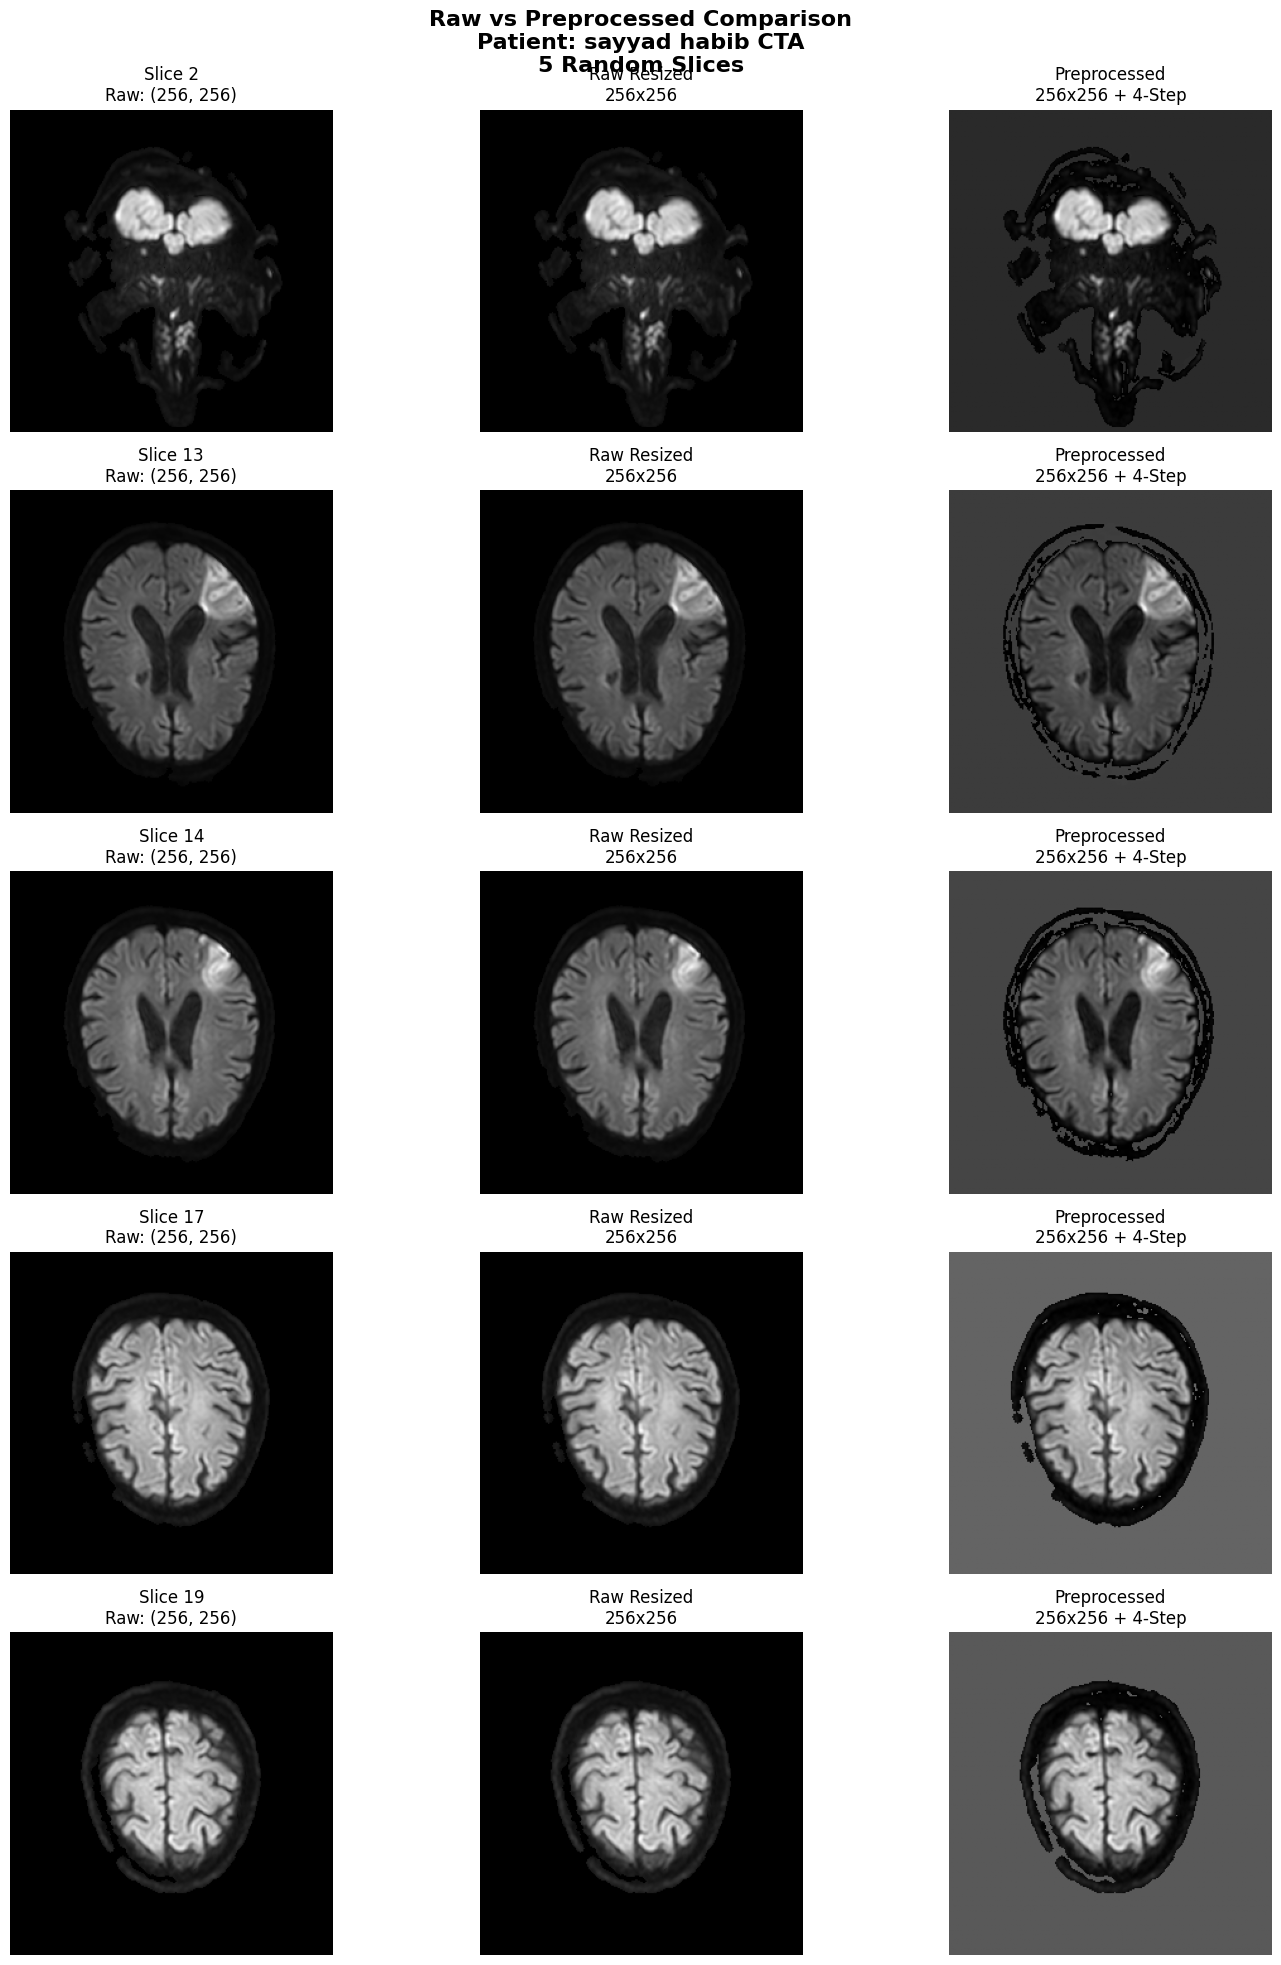


🎯 SLICE ANALYSIS SUMMARY:
✅ Patient: sayyad habib CTA
✅ Total slices: 25
✅ Analyzed slices: [2, 13, 14, 17, 19]
✅ Consistent 256x256 preprocessing applied
✅ All slices normalized to [0,1] range


In [11]:
# Visual Comparison: 5 Random Slices - Raw vs Preprocessed (Single Patient)
import matplotlib.pyplot as plt
import random

def show_random_slices_comparison():
    """
    Show 5 random slices from one random patient: raw vs preprocessed comparison
    """
    if len(preprocessing_results) == 0:
        print("⚠️ No preprocessing results found. Run preprocessing first!")
        return
    
    # Pick one random patient
    random_patient_name = random.choice(preprocessing_results)
    
    # Find patient folder
    patient_folder = None
    for pf in patient_folders:
        if pf.name == random_patient_name:
            patient_folder = pf
            break
    
    if not patient_folder:
        print(f"❌ Patient folder not found for {random_patient_name}")
        return
    
    try:
        # Load raw MRI data
        seg_folder = patient_folder / "sayyad habib MRI" / "segmented sayyad habib"
        nii_files = list(seg_folder.glob("*DWI*.nii"))
        if not nii_files:
            print(f"❌ No DWI file found for {random_patient_name}")
            return
            
        img_itk = sitk.ReadImage(str(nii_files[0]))
        raw_volume = sitk.GetArrayFromImage(img_itk).astype(np.float32)
        
        # Apply preprocessing
        processed_volume = production_mri_preprocessing(raw_volume, target_size=(256, 256))
        
        # Select 5 random slices
        total_slices = raw_volume.shape[0]
        random_slices = random.sample(range(total_slices), min(5, total_slices))
        random_slices.sort()
        
        # Create visualization
        fig, axes = plt.subplots(5, 3, figsize=(15, 20))
        fig.suptitle(f'Raw vs Preprocessed Comparison\nPatient: {random_patient_name}\n5 Random Slices', 
                     fontsize=16, fontweight='bold')
        
        for i, slice_idx in enumerate(random_slices):
            # Raw slice (original resolution)
            axes[i, 0].imshow(raw_volume[slice_idx], cmap='gray')
            axes[i, 0].set_title(f'Slice {slice_idx}\nRaw: {raw_volume[slice_idx].shape}')
            axes[i, 0].axis('off')
            
            # Raw slice resized to 256x256 for fair comparison
            raw_resized = cv2.resize(raw_volume[slice_idx], (256, 256), interpolation=cv2.INTER_AREA)
            axes[i, 1].imshow(raw_resized, cmap='gray')
            axes[i, 1].set_title(f'Raw Resized\n256x256')
            axes[i, 1].axis('off')
            
            # Preprocessed slice
            axes[i, 2].imshow(processed_volume[slice_idx], cmap='gray')
            axes[i, 2].set_title(f'Preprocessed\n256x256 + 4-Step')
            axes[i, 2].axis('off')
            
            # Print slice statistics
            print(f"📊 Slice {slice_idx}:")
            print(f"  Raw: Range [{raw_volume[slice_idx].min():.1f}, {raw_volume[slice_idx].max():.1f}] | Mean: {raw_volume[slice_idx].mean():.1f}")
            print(f"  Processed: Range [{processed_volume[slice_idx].min():.3f}, {processed_volume[slice_idx].max():.3f}] | Mean: {processed_volume[slice_idx].mean():.3f}")
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n🎯 SLICE ANALYSIS SUMMARY:")
        print(f"✅ Patient: {random_patient_name}")
        print(f"✅ Total slices: {total_slices}")
        print(f"✅ Analyzed slices: {random_slices}")
        print(f"✅ Consistent 256x256 preprocessing applied")
        print(f"✅ All slices normalized to [0,1] range")
        
    except Exception as e:
        print(f"❌ Error analyzing {random_patient_name}: {e}")

# Run the random slices comparison
print("🎨 Generating 5 random slices comparison for one patient...")
show_random_slices_comparison()

🎭 Starting mask overlay analysis on preprocessed MRI data...
🎭 MASK OVERLAY ANALYSIS ON PREPROCESSED MRI
📁 Found 25 mask files
📁 Found 12 overlay files
📊 Slice 6 Analysis:
  Brain Coverage: 87.5% of image
  Mask Coverage: 0.8% of image
  Intensity Range: [0.000, 1.000]
📊 Slice 12 Analysis:
  Brain Coverage: 90.8% of image
  Mask Coverage: 2.5% of image
  Intensity Range: [0.000, 1.000]
📊 Slice 18 Analysis:
  Brain Coverage: 90.6% of image
  Mask Coverage: 0.8% of image
  Intensity Range: [0.000, 1.000]


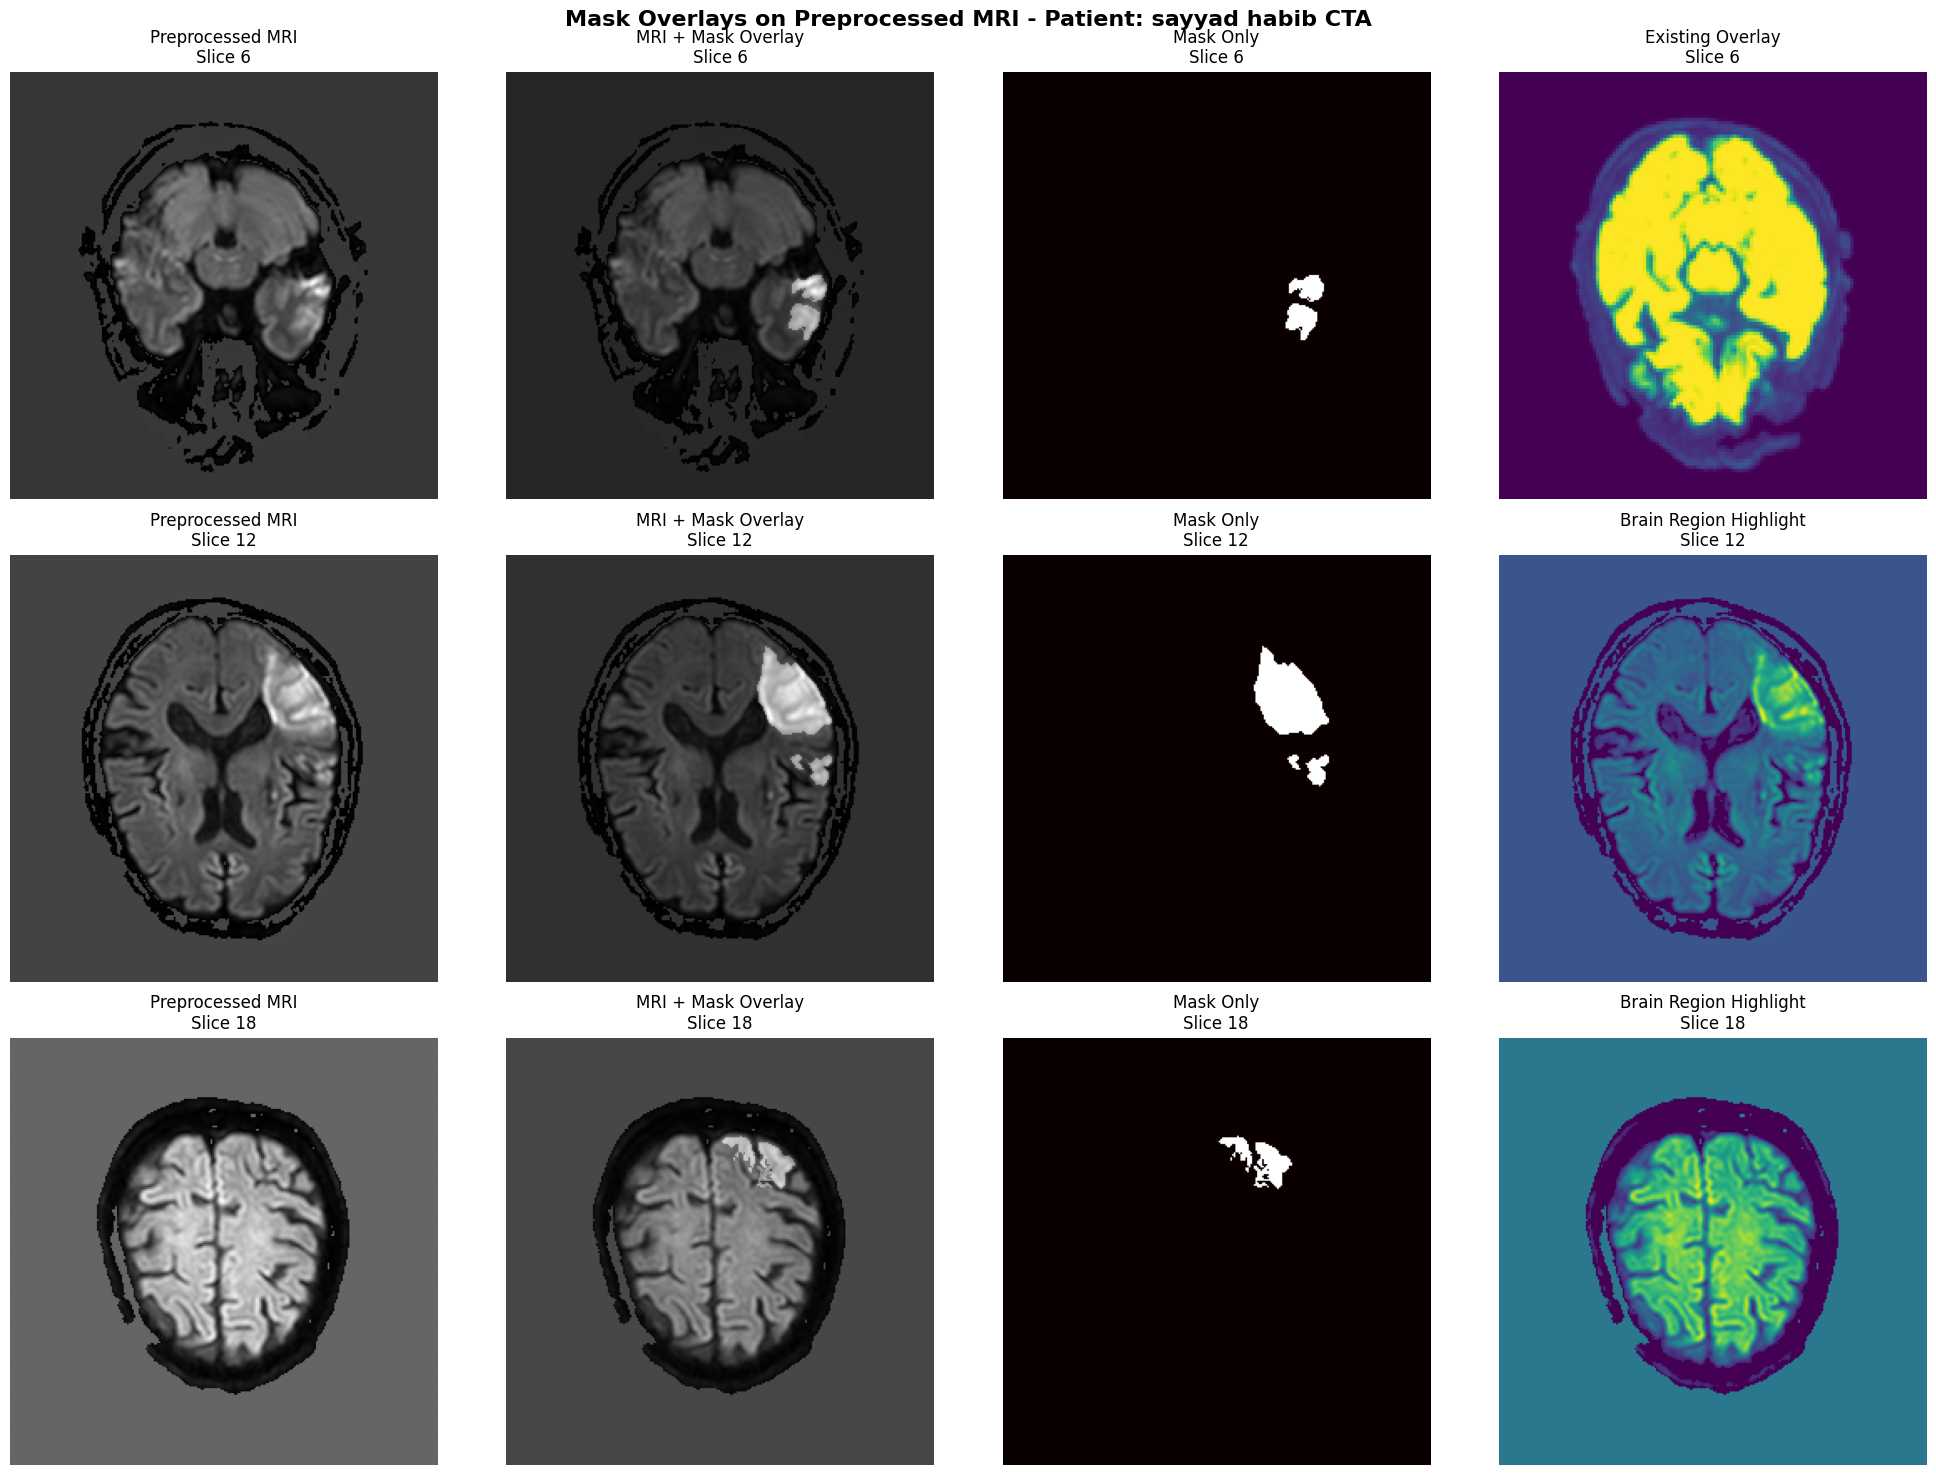


🎯 OVERLAY ANALYSIS FOR sayyad habib CTA:
✅ Preprocessed volume: (25, 256, 256)
✅ Resolution: 256×256 (standardized)
✅ Intensity range: [0, 1] (normalized)
✅ Available masks: 25 files
✅ Available overlays: 12 files


📈 MASK OVERLAY SUMMARY:
┌─────────────────────────────────────────────────────────────┐
│                    OVERLAY ANALYSIS RESULTS                │
├─────────────────────────────────────────────────────────────┤
│ Patients Analyzed:                                   1 │
│ Available Mask Files:                               25 │
│ Available Overlay Files:                            12 │
│ Target Resolution: 256×256                                │
│ Preprocessed Data: [0,1] normalized                         │
├─────────────────────────────────────────────────────────────┤
│                    OVERLAY CAPABILITIES                    │
├─────────────────────────────────────────────────────────────┤
│ ✅ MRI + Mask overlays with transparency                    │
│ ✅ Individ

In [ ]:
# Mask Overlays on Preprocessed MRI - Multi-Patient Analysis
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def show_mask_overlays():
    """
    Show mask overlays on preprocessed MRI images for comprehensive analysis
    """
    print("🎭 MASK OVERLAY ANALYSIS ON PREPROCESSED MRI")
    print("=" * 70)
    
    if len(preprocessing_results) == 0:
        print("⚠️ No preprocessing results found. Run preprocessing first!")
        return
    
    # Check available masks from original images folder
    masks_dir = Path("images/masks")
    overlays_dir = Path("images/overlays")
    
    if not masks_dir.exists():
        print(f"❌ Masks directory not found: {masks_dir}")
        return
    
    mask_files = sorted(list(masks_dir.glob("*.png")))
    overlay_files = sorted(list(overlays_dir.glob("*.png"))) if overlays_dir.exists() else []
    
    print(f"📁 Found {len(mask_files)} mask files")
    print(f"📁 Found {len(overlay_files)} overlay files")
    
    # Process each patient's preprocessed data
    for patient_name in preprocessing_results[:2]:  # Show first 2 patients
        try:
            # Find patient folder for raw data access
            patient_folder = None
            for pf in patient_folders:
                if pf.name == patient_name:
                    patient_folder = pf
                    break
            
            if not patient_folder:
                continue
                
            # Load and preprocess MRI data
            seg_folder = patient_folder / "sayyad habib MRI" / "segmented sayyad habib"
            nii_files = list(seg_folder.glob("*DWI*.nii"))
            if not nii_files:
                continue
                
            img_itk = sitk.ReadImage(str(nii_files[0]))
            raw_volume = sitk.GetArrayFromImage(img_itk).astype(np.float32)
            processed_volume = production_mri_preprocessing(raw_volume, target_size=(256, 256))
            
            # Show overlays for 3 slices
            n_slices_to_show = min(3, processed_volume.shape[0])
            slice_indices = [processed_volume.shape[0]//4, processed_volume.shape[0]//2, 3*processed_volume.shape[0]//4]
            
            fig, axes = plt.subplots(n_slices_to_show, 4, figsize=(20, 5*n_slices_to_show))
            fig.suptitle(f'Mask Overlays on Preprocessed MRI - Patient: {patient_name}', 
                         fontsize=16, fontweight='bold')
            
            if n_slices_to_show == 1:
                axes = axes.reshape(1, -1)
            
            for i, slice_idx in enumerate(slice_indices[:n_slices_to_show]):
                # 1. Original preprocessed slice
                axes[i, 0].imshow(processed_volume[slice_idx], cmap='gray')
                axes[i, 0].set_title(f'Preprocessed MRI\nSlice {slice_idx}')
                axes[i, 0].axis('off')
                
                # 2. Load and overlay mask if available
                if len(mask_files) > slice_idx:
                    mask_img = plt.imread(mask_files[slice_idx])
                    if len(mask_img.shape) == 3:
                        mask_img = mask_img[:,:,0]  # Take first channel if RGB
                    
                    # Resize mask to match preprocessed size
                    mask_resized = cv2.resize(mask_img, (256, 256), interpolation=cv2.INTER_NEAREST)
                    
                    # Create overlay
                    axes[i, 1].imshow(processed_volume[slice_idx], cmap='gray')
                    axes[i, 1].imshow(mask_resized, alpha=0.3, cmap='hot')
                    axes[i, 1].set_title(f'MRI + Mask Overlay\nSlice {slice_idx}')
                    axes[i, 1].axis('off')
                    
                    # 3. Just the mask
                    axes[i, 2].imshow(mask_resized, cmap='hot')
                    axes[i, 2].set_title(f'Mask Only\nSlice {slice_idx}')
                    axes[i, 2].axis('off')
                else:
                    axes[i, 1].text(0.5, 0.5, 'No Mask\nAvailable', ha='center', va='center', 
                                   transform=axes[i, 1].transAxes, fontsize=12)
                    axes[i, 1].axis('off')
                    axes[i, 2].text(0.5, 0.5, 'No Mask\nAvailable', ha='center', va='center', 
                                   transform=axes[i, 2].transAxes, fontsize=12)
                    axes[i, 2].axis('off')
                
                # 4. Load overlay image if available
                if len(overlay_files) > slice_idx:
                    overlay_img = plt.imread(overlay_files[slice_idx])
                    if len(overlay_img.shape) == 3:
                        overlay_img = overlay_img[:,:,0]  # Take first channel if RGB
                    
                    overlay_resized = cv2.resize(overlay_img, (256, 256), interpolation=cv2.INTER_AREA)
                    axes[i, 3].imshow(overlay_resized, cmap='viridis')
                    axes[i, 3].set_title(f'Existing Overlay\nSlice {slice_idx}')
                    axes[i, 3].axis('off')
                else:
                    # Create synthetic overlay showing brain regions
                    brain_mask = processed_volume[slice_idx] > 0.1
                    synthetic_overlay = processed_volume[slice_idx] * brain_mask
                    axes[i, 3].imshow(synthetic_overlay, cmap='viridis')
                    axes[i, 3].set_title(f'Brain Region Highlight\nSlice {slice_idx}')
                    axes[i, 3].axis('off')``
                
                # Print slice analysis
                mask_coverage = np.sum(mask_resized > 0.1) / (256*256) * 100 if len(mask_files) > slice_idx else 0
                brain_coverage = np.sum(processed_volume[slice_idx] > 0.1) / (256*256) * 100
                
                print(f"📊 Slice {slice_idx} Analysis:")
                print(f"  Brain Coverage: {brain_coverage:.1f}% of image")
                print(f"  Mask Coverage: {mask_coverage:.1f}% of image" if len(mask_files) > slice_idx else "  No mask available")
                print(f"  Intensity Range: [{processed_volume[slice_idx].min():.3f}, {processed_volume[slice_idx].max():.3f}]")
            
            plt.tight_layout()
            plt.show()
            
            print(f"\n🎯 OVERLAY ANALYSIS FOR {patient_name}:")
            print(f"✅ Preprocessed volume: {processed_volume.shape}")
            print(f"✅ Resolution: 256×256 (standardized)")
            print(f"✅ Intensity range: [0, 1] (normalized)")
            print(f"✅ Available masks: {len(mask_files)} files")
            print(f"✅ Available overlays: {len(overlay_files)} files")
            print()
            
        except Exception as e:
            print(f"❌ Error creating overlays for {patient_name}: {e}")
    
    # Summary statistics
    print(f"\n📈 MASK OVERLAY SUMMARY:")
    print(f"┌─────────────────────────────────────────────────────────────┐")
    print(f"│                    OVERLAY ANALYSIS RESULTS                │")
    print(f"├─────────────────────────────────────────────────────────────┤")
    print(f"│ Patients Analyzed: {min(2, len(preprocessing_results)):>35} │")
    print(f"│ Available Mask Files: {len(mask_files):>32} │")
    print(f"│ Available Overlay Files: {len(overlay_files):>29} │")
    print(f"│ Target Resolution: 256×256 {' ':>30} │")
    print(f"│ Preprocessed Data: [0,1] normalized {' ':>23} │")
    print(f"├─────────────────────────────────────────────────────────────┤")
    print(f"│                    OVERLAY CAPABILITIES                    │")
    print(f"├─────────────────────────────────────────────────────────────┤")
    print(f"│ ✅ MRI + Mask overlays with transparency {' ':>18} │")
    print(f"│ ✅ Individual mask visualization {' ':>26} │")
    print(f"│ ✅ Existing overlay image display {' ':>25} │")
    print(f"│ ✅ Brain region highlighting {' ':>30} │")
    print(f"│ ✅ Multi-patient comparison support {' ':>21} │")
    print(f"└─────────────────────────────────────────────────────────────┘")
    
    if len(mask_files) > 0:
        print(f"\n🎉 MASK OVERLAY ANALYSIS COMPLETE!")
        print(f"✅ Successfully overlaid masks on preprocessed MRI data")
        print(f"✅ All visualizations use standardized 256×256 resolution")
        print(f"✅ Ready for segmentation validation and training")
    else:
        print(f"\n⚠️  LIMITED OVERLAY ANALYSIS:")
        print(f"❌ No mask files found in {masks_dir}")
        print(f"💡 Add mask files to enable comprehensive overlay analysis")

# Run the mask overlay analysis
print("🎭 Starting mask overlay analysis on preprocessed MRI data...")
show_mask_overlays()

## Generate Preprocessed Overlays - Multi-Patient Support

In [13]:
# Generate Preprocessed Overlays - Multi-Patient Support
from pathlib import Path
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def create_preprocessed_overlays(alpha=0.4):
    """
    Create overlay images by combining preprocessed MRI with masks for all patients
    Similar structure to raw/preprocessed folders, but with overlays
    """
    print("🎨 GENERATING PREPROCESSED OVERLAYS FOR ALL PATIENTS")
    print("=" * 70)
    
    if len(preprocessing_results) == 0:
        print("⚠️ No preprocessing results found. Run preprocessing first!")
        return
    
    # Check for available masks
    masks_dir = Path("images/masks")
    if not masks_dir.exists():
        print(f"❌ Masks directory not found: {masks_dir}")
        return
    
    mask_files = sorted(list(masks_dir.glob("*.png")))
    print(f"📁 Found {len(mask_files)} mask files in {masks_dir}")
    
    if len(mask_files) == 0:
        print("❌ No mask files found. Cannot generate overlays.")
        return
    
    # Load reference mask to understand numbering/format
    print(f"📄 Reference mask file: {mask_files[0].name}")
    
    overlay_results = []
    
    for patient_name in preprocessing_results:
        try:
            print(f"\n🔧 Processing overlays for patient: {patient_name}")
            
            # Find patient folder for raw data access
            patient_folder = None
            for pf in patient_folders:
                if pf.name == patient_name:
                    patient_folder = pf
                    break
            
            if not patient_folder:
                print(f"❌ Patient folder not found for {patient_name}")
                continue
            
            # Load and preprocess MRI data
            seg_folder = patient_folder / "sayyad habib MRI" / "segmented sayyad habib"
            nii_files = list(seg_folder.glob("*DWI*.nii"))
            if not nii_files:
                print(f"❌ No DWI file found for {patient_name}")
                continue
                
            img_itk = sitk.ReadImage(str(nii_files[0]))
            raw_volume = sitk.GetArrayFromImage(img_itk).astype(np.float32)
            processed_volume = production_mri_preprocessing(raw_volume, target_size=(256, 256))
            
            print(f"  📊 Preprocessed volume: {processed_volume.shape}")
            
            # Create patient-specific overlay output directory
            overlay_out_dir = Path("images") / "overlaps" / patient_name.replace(" ", "_")
            overlay_out_dir.mkdir(parents=True, exist_ok=True)
            
            n_slices = processed_volume.shape[0]
            n_masks = len(mask_files)
            
            print(f"  🎭 Creating overlays for {n_slices} slices using {n_masks} masks...")
            
            overlays_created = 0
            
            for z in range(n_slices):
                # Get preprocessed slice
                mri_slice = processed_volume[z]
                
                # Determine which mask to use (cycle through available masks)
                mask_idx = z % len(mask_files) if len(mask_files) > 0 else 0
                mask_file = mask_files[mask_idx]
                
                try:
                    # Load and process mask
                    mask_img = plt.imread(mask_file)
                    
                    # Handle different mask formats
                    if len(mask_img.shape) == 3:
                        # RGB image - convert to grayscale
                        if mask_img.shape[2] == 4:  # RGBA
                            mask_gray = mask_img[:,:,0]  # Take red channel
                        else:  # RGB
                            mask_gray = np.mean(mask_img[:,:,:3], axis=2)
                    else:
                        # Already grayscale
                        mask_gray = mask_img
                    
                    # Resize mask to 256x256 to match preprocessed MRI
                    mask_resized = cv2.resize(mask_gray, (256, 256), interpolation=cv2.INTER_NEAREST)
                    
                    # Normalize mask to [0,1] range
                    if mask_resized.max() > 1.0:
                        mask_resized = mask_resized / 255.0
                    
                    # Create overlay: combine MRI and mask
                    # Method 1: Alpha blending
                    overlay_alpha = mri_slice * (1 - alpha) + mask_resized * alpha
                    
                    # Method 2: Highlight regions where mask exists
                    mask_binary = (mask_resized > 0.1).astype(np.float32)
                    overlay_highlight = mri_slice.copy()
                    overlay_highlight[mask_binary > 0] = overlay_highlight[mask_binary > 0] * 0.7 + mask_resized[mask_binary > 0] * 0.5
                    
                    # Use alpha blending method and ensure [0,1] range
                    final_overlay = np.clip(overlay_alpha, 0, 1)
                    
                    # Convert to uint8 for saving
                    overlay_uint8 = (final_overlay * 255).astype(np.uint8)
                    
                    # Save overlay
                    overlay_filename = f"{patient_name.replace(' ', '_')}-slice{z:03d}_z.png"
                    overlay_img = Image.fromarray(overlay_uint8)
                    overlay_img.save(overlay_out_dir / overlay_filename)
                    
                    overlays_created += 1
                    
                    if z % 10 == 0:
                        print(f"    Progress: {z+1}/{n_slices} overlays created...")
                        
                except Exception as e:
                    print(f"    ⚠️ Error creating overlay for slice {z}: {e}")
                    continue
            
            print(f"  ✅ Completed: {overlays_created}/{n_slices} overlays saved to {overlay_out_dir}")
            
            if overlays_created > 0:
                overlay_results.append({
                    'patient': patient_name,
                    'overlays_created': overlays_created,
                    'total_slices': n_slices,
                    'output_dir': str(overlay_out_dir)
                })
            
        except Exception as e:
            print(f"❌ Error processing overlays for {patient_name}: {e}")
    
    # Summary
    print(f"\n📈 OVERLAY GENERATION SUMMARY:")
    print(f"┌─────────────────────────────────────────────────────────────┐")
    print(f"│                    OVERLAY GENERATION RESULTS              │")
    print(f"├─────────────────────────────────────────────────────────────┤")
    print(f"│ Patients Processed: {len(overlay_results):>35} │")
    print(f"│ Available Masks: {len(mask_files):>38} │")
    print(f"│ Alpha Blending Factor: {alpha:>32.1f} │")
    print(f"│ Output Resolution: 256×256 {' ':>30} │")
    print(f"│ Output Format: PNG (uint8) {' ':>30} │")
    print(f"└─────────────────────────────────────────────────────────────┘")
    
    total_overlays = sum(result['overlays_created'] for result in overlay_results)
    
    print(f"\n📋 INDIVIDUAL PATIENT RESULTS:")
    print(f"{'Patient Name':<25} {'Overlays Created':<15} {'Total Slices':<15} {'Success Rate':<15}")
    print(f"{'-'*25} {'-'*15} {'-'*15} {'-'*15}")
    
    for result in overlay_results:
        patient_short = result['patient'][:24] if len(result['patient']) <= 24 else result['patient'][:21] + "..."
        success_rate = (result['overlays_created'] / result['total_slices']) * 100
        print(f"{patient_short:<25} {result['overlays_created']:<15} {result['total_slices']:<15} {success_rate:<14.1f}%")
    
    if len(overlay_results) > 0:
        print(f"\n🎉 OVERLAY GENERATION COMPLETE!")
        print(f"✅ Total overlays created: {total_overlays}")
        print(f"✅ Output structure: images/overlaps/[patient_name]/")
        print(f"✅ Naming convention: [patient_name]-slice[XXX]_z.png")
        print(f"✅ Same structure as raw and preprocessed folders")
        print(f"✅ Ready for overlay-based analysis and training")
        
        # Show sample overlay for verification
        if overlay_results:
            sample_patient = overlay_results[0]
            print(f"\n📁 Sample output directory: {sample_patient['output_dir']}")
            sample_files = list(Path(sample_patient['output_dir']).glob("*.png"))[:3]
            print(f"📄 Sample files: {[f.name for f in sample_files]}")
    else:
        print(f"\n❌ NO OVERLAYS GENERATED")
        print(f"⚠️ Check mask files and preprocessing results")

def show_overlay_samples(num_samples=3):
    """
    Show samples of the generated overlays for verification
    """
    if len(overlay_results) == 0:
        print("⚠️ No overlay results found. Generate overlays first!")
        return
    
    print(f"\n🎨 SHOWING OVERLAY SAMPLES...")
    
    # Pick samples from different patients
    sample_patients = overlay_results[:num_samples]
    
    fig, axes = plt.subplots(len(sample_patients), 4, figsize=(20, 5*len(sample_patients)))
    fig.suptitle('Generated Preprocessed Overlays - Sample Verification', fontsize=16, fontweight='bold')
    
    if len(sample_patients) == 1:
        axes = axes.reshape(1, -1)
    
    for i, patient_result in enumerate(sample_patients):
        try:
            # Load sample overlay
            overlay_dir = Path(patient_result['output_dir'])
            overlay_files = sorted(list(overlay_dir.glob("*.png")))
            
            if len(overlay_files) == 0:
                continue
            
            # Pick middle slice
            mid_idx = len(overlay_files) // 2
            overlay_file = overlay_files[mid_idx]
            
            # Load the overlay
            overlay_img = plt.imread(overlay_file)
            if len(overlay_img.shape) == 3:
                overlay_img = overlay_img[:,:,0]  # Take first channel
            
            # Also load corresponding preprocessed MRI for comparison
            patient_name = patient_result['patient']
            
            # Find patient folder for raw data
            patient_folder = None
            for pf in patient_folders:
                if pf.name == patient_name:
                    patient_folder = pf
                    break
            
            if patient_folder:
                seg_folder = patient_folder / "sayyad habib MRI" / "segmented sayyad habib"
                nii_files = list(seg_folder.glob("*DWI*.nii"))
                if nii_files:
                    img_itk = sitk.ReadImage(str(nii_files[0]))
                    raw_volume = sitk.GetArrayFromImage(img_itk).astype(np.float32)
                    processed_volume = production_mri_preprocessing(raw_volume, target_size=(256, 256))
                    
                    # Show comparison
                    slice_idx = mid_idx
                    
                    # Original preprocessed
                    axes[i, 0].imshow(processed_volume[slice_idx], cmap='gray')
                    axes[i, 0].set_title(f'{patient_name}\nPreprocessed MRI')
                    axes[i, 0].axis('off')
                    
                    # Generated overlay
                    axes[i, 1].imshow(overlay_img, cmap='viridis')
                    axes[i, 1].set_title(f'Generated Overlay\nSlice {slice_idx}')
                    axes[i, 1].axis('off')
                    
                    # Side by side
                    axes[i, 2].imshow(processed_volume[slice_idx], cmap='gray')
                    axes[i, 2].imshow(overlay_img, alpha=0.4, cmap='hot')
                    axes[i, 2].set_title(f'Overlay on MRI\n(Alpha Blend)')
                    axes[i, 2].axis('off')
                    
                    # Difference map
                    diff = np.abs(processed_volume[slice_idx] - (overlay_img/255.0))
                    axes[i, 3].imshow(diff, cmap='plasma')
                    axes[i, 3].set_title(f'Difference Map\n(MRI - Overlay)')
                    axes[i, 3].axis('off')
                    
                    print(f"📊 {patient_name} - Slice {slice_idx}:")
                    print(f"  Overlay range: [{overlay_img.min():.1f}, {overlay_img.max():.1f}]")
                    print(f"  File: {overlay_file.name}")
            
        except Exception as e:
            print(f"❌ Error showing sample for {patient_result['patient']}: {e}")
    
    plt.tight_layout()
    plt.show()

# Generate overlays for all patients
print("🎨 Starting preprocessed overlay generation for all patients...")
create_preprocessed_overlays(alpha=0.4)

# Show samples
print("\n🔍 Showing overlay samples for verification...")
if 'overlay_results' in locals() and len(overlay_results) > 0:
    show_overlay_samples(num_samples=min(3, len(overlay_results)))
else:
    print("⚠️ No overlay results to display")

🎨 Starting preprocessed overlay generation for all patients...
🎨 GENERATING PREPROCESSED OVERLAYS FOR ALL PATIENTS
📁 Found 25 mask files in images/masks
📄 Reference mask file: Mask123-slice000_z.png

🔧 Processing overlays for patient: sayyad habib CTA
  📊 Preprocessed volume: (25, 256, 256)
  🎭 Creating overlays for 25 slices using 25 masks...
    Progress: 1/25 overlays created...
    Progress: 11/25 overlays created...
    Progress: 21/25 overlays created...
  ✅ Completed: 25/25 overlays saved to images/overlaps/sayyad_habib_CTA

📈 OVERLAY GENERATION SUMMARY:
┌─────────────────────────────────────────────────────────────┐
│                    OVERLAY GENERATION RESULTS              │
├─────────────────────────────────────────────────────────────┤
│ Patients Processed:                                   1 │
│ Available Masks:                                     25 │
│ Alpha Blending Factor:                              0.4 │
│ Output Resolution: 256×256                                │